In [1]:
import sys
import os
import numpy as np
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe# Only add the project root to sys.path
import stumpy
from stumpy.floss import _rea
root_path = os.path.abspath('..')
if root_path not in sys.path:
    sys.path.insert(0, root_path)
    
functions_path = os.path.abspath('../Functions')
data_path = os.path.abspath('../Data')
algorithms_path = os.path.abspath('../Algorithms')

sys.path.append(functions_path)
sys.path.append(data_path)
sys.path.append(algorithms_path)

In [8]:
def evaluate_floss(dataset, routine, subject, sensor, sample_rate, cps, activities, ts, **seg_kwargs):
    print(f"{ts}")
    print(f"{ts.shape}")
    profile, found_cps = floss(ts, 20*sample_rate, sample_rate, n_cps=len(cps), return_cac=True, **seg_kwargs)

    f1_score = f_measure({0: cps}, found_cps, margin=int(ts.shape[0] * .01))
    covering_score = covering({0: cps}, found_cps, ts.shape[0])

    # Corrected return statement
    return dataset, cps, found_cps, np.round(f1_score, 3), np.round(covering_score, 3), profile

In [9]:
def floss(ts, sliding_window_size, window_size, n_cps, return_cac=False):
    print(f"{ts}")
    print(f"{ts.shape}")
    mp = stumpy.stump(ts[:sliding_window_size], m=window_size)

    stream = stumpy.floss(
        mp,
        ts[:sliding_window_size],
        m=window_size,
        L=window_size
    )

    cac = np.full(ts.shape[0], fill_value=np.inf, dtype=np.float64)

    for dx, timepoint in zip(range(sliding_window_size, ts.shape[0]), ts[sliding_window_size:]):
        stream.update(timepoint)
        window_cac = stream.cac_1d_

        cac[max(0, dx - window_cac.shape[0]+1):dx+1] = np.min([
            cac[max(0, dx - window_cac.shape[0]+1):dx+1],
            window_cac[max(0, window_cac.shape[0]-dx-1):]
        ], axis=0)

    cps = _rea(cac, L=window_size, n_regimes=n_cps+1)

    if return_cac is True:
        return cac, cps

    return cps

[1.668728 1.811384 0.156194 ... 0.55712  0.516611 0.582651]
(3092,)
[1.668728 1.811384 0.156194 ... 0.55712  0.516611 0.582651]
(3092,)


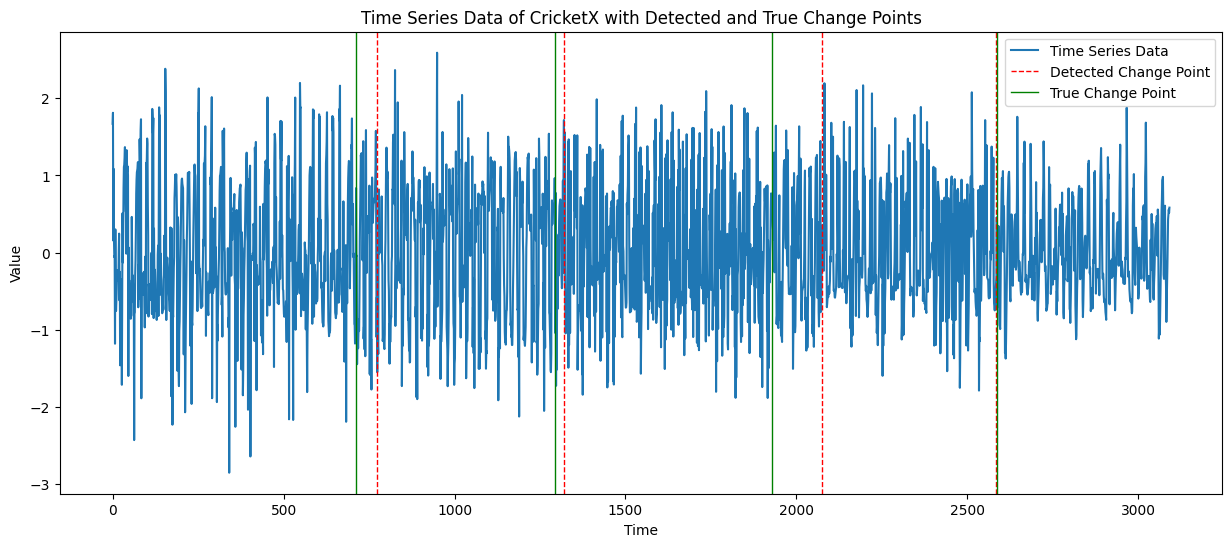

F1 Score: 0.6
Covering Score: 0.861


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from Functions.metrics import f_measure, covering
from Functions.true_cps import read_true_change_points
from Functions.evaluate_floss import evaluate_floss
# from coverage import calculate_coverage_score

## Define the dataset name and other parameters (adjust as necessary)
dataset_name = 'CricketX'
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = 100

# Load the dataset
data_path = f'../Data/{dataset_name}.txt'
data = np.loadtxt(data_path)

# Read true change points
desc_path = '../Data/TrueCPS/desc.txt'
true_change_points = read_true_change_points(desc_path, dataset_name)

# Apply FLOSS and evaluate its performance
_, _, found_cps, f1_score, covering_score, _ = evaluate_floss(
    dataset_name, routine, subject, sensor, sample_rate,
    true_change_points, [], data
)

# Visualization
plt.figure(figsize=(15, 6))  # Adjust the figure size to make it wider
plt.plot(data, label='Time Series Data')

# Draw vertical lines for each detected change point
for cp in found_cps:
    plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == found_cps[0] else "")

# Draw vertical lines for each true change point
for cp in true_change_points:
    plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series Data of {dataset_name} with Detected and True Change Points')
plt.legend()
plt.show()

# Print the performance metrics
print(f"F1 Score: {f1_score}")
print(f"Covering Score: {covering_score}")

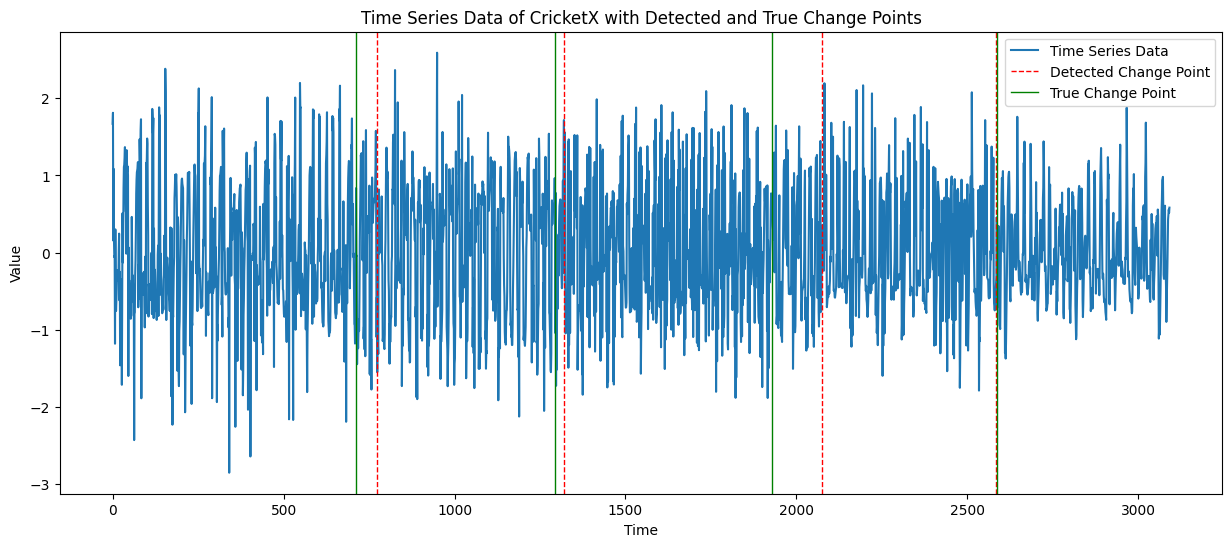

F1 Score: 0.6
Covering Score: 0.861


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from Functions.metrics import f_measure, covering
from Functions.true_cps import read_true_change_points
# from Functions.evaluate_floss import evaluate_floss
# from coverage import calculate_coverage_score

## Define the dataset name and other parameters (adjust as necessary)
dataset_name = 'CricketX'
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'
sample_rate = 100

# Load the dataset
data_path = f'../Data/{dataset_name}.txt'
data = np.loadtxt(data_path)

# Read true change points
desc_path = '../Data/TrueCPS/desc.txt'
true_change_points = read_true_change_points(desc_path, dataset_name)

# Apply FLOSS and evaluate its performance
_, _, found_cps, f1_score, covering_score, _ = evaluate_floss(
    dataset_name, routine, subject, sensor, sample_rate,
    true_change_points, [], data
)

# Visualization
plt.figure(figsize=(15, 6))  # Adjust the figure size to make it wider
plt.plot(data, label='Time Series Data')

# Draw vertical lines for each detected change point
for cp in found_cps:
    plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == found_cps[0] else "")

# Draw vertical lines for each true change point
for cp in true_change_points:
    plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Time Series Data of {dataset_name} with Detected and True Change Points')
plt.legend()
plt.show()

# Print the performance metrics
print(f"F1 Score: {f1_score}")
print(f"Covering Score: {covering_score}")

In [40]:
data = np.load('saved_data//time_series_P6_A.npy')
print(data[0])

cp = np.load('saved_data//true_change_points_P6_A.npy')
print(cp[2])

[1.298237 1.419932 1.149522 ... 0.69874  1.609866 1.632248]
174


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from Algorithms.floss import floss
# from Functions.evaluate_floss import evaluate_floss

# Load the time series data and true change points
time_series_file = 'saved_data//time_series_P6_A.npy'
change_points_file = 'saved_data//true_change_points_P6_A.npy'

time_series = np.load(time_series_file, allow_pickle=True)
true_change_points = np.load(change_points_file, allow_pickle=True)

# Define the labels for each series in the time series data
series_labels = [
    'B8E3_Waist_Accel_LN_X', 'B8E3_Waist_Accel_LN_Y', 'B8E3_Waist_Accel_LN_Z',
    'B8E3_Waist_Gyro_X', 'B8E3_Waist_Gyro_Y', 'B8E3_Waist_Gyro_Z', 
    'B8E3_Waist_Mag_X', 'B8E3_Waist_Mag_Y', 'B8E3_Waist_Mag_Z'
]

# Initialize accumulators for total time, F1 score, and coverage score
total_time = 0
total_f1_score = 0
total_covering_score = 0
series_processed = 0

# Define a sample rate for FLoSS (adjust as necessary)
sample_rate = 100

for i, single_series in enumerate(time_series):
    series_identifier = series_labels[i]

    # Adjust sliding_window_size and window_size as needed
    sliding_window_size = 100
    window_size = 50
    n_cps = min(len(true_change_points), len(single_series) - 1)

    start_time = time.time()
    detected_cps = floss(single_series, sliding_window_size, window_size, n_cps)
    print(f"{detected_cps}")
    end_time = time.time()

    algorithm_duration = end_time - start_time
    total_time += algorithm_duration

    try:
        # Uncomment and modify this line as needed if evaluate_floss is available
        # dataset, true_cps, detected_cps, f1_score, covering_score, profile = evaluate_floss(
        #     series_identifier, sample_rate, true_change_points, single_series
        # )

        f1_score = 0 # Placeholder, replace with actual computation
        covering_score = 0 # Placeholder, replace with actual computation
        print(f"{series_identifier} - True Change Points: {sorted(true_change_points)}")
        print(f"{series_identifier} - Detected Change Points: {detected_cps}")
        print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
        print(f"{series_identifier} - Algorithm Duration: {algorithm_duration:.2f} seconds")

        total_f1_score += f1_score
        total_covering_score += covering_score
        series_processed += 1

    except TypeError as e:
        print(f"An error occurred for {series_identifier}: {e}")

    plt.figure(figsize=(15, 6))
    plt.plot(single_series, label='Time Series Data')
    for cp in detected_cps:
        plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == detected_cps[0] else "")
    for cp in true_change_points:
        plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
    plt.legend()
    plt.show()

# Compute the average metrics
average_time = total_time / series_processed if series_processed > 0 else 0
average_f1_score = total_f1_score / series_processed if series_processed > 0 else 0
average_covering_score = total_covering_score / series_processed if series_processed > 0 else 0

# Print the average metrics
print(f"Average Time: {average_time:.2f} seconds")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Average Covering Score")


[100   0   0   0   0   0   0   0   0   0   0]
P53_N_B8E3_Waist_Accel_LN_X - True Change Points: [278, 440, 626, 813, 1000, 1191, 1396, 1587, 1803, 2033, 2247]
P53_N_B8E3_Waist_Accel_LN_X - Detected Change Points: [1319 2076  772 2583]
P53_N_B8E3_Waist_Accel_LN_X - F1 Score: 0.154, Covering Score: 0.125
P53_N_B8E3_Waist_Accel_LN_X - Algorithm Duration: 2.12 seconds


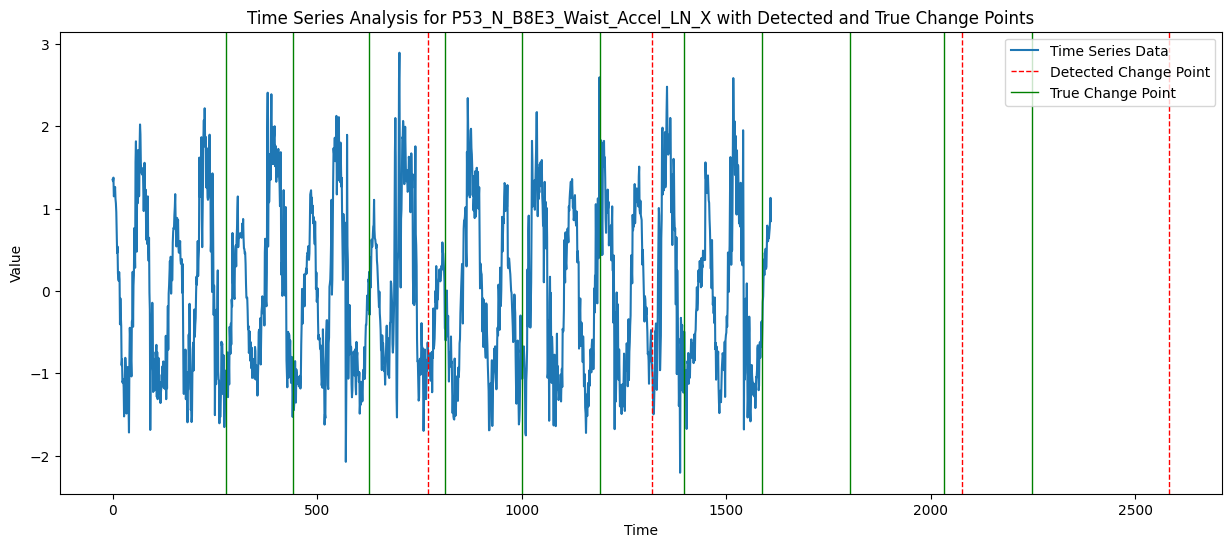

KeyboardInterrupt: 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.floss import floss
# from Functions.evaluate_floss import evaluate_floss
import time

# Load the time series data and change points
ts_file_path = '..//Data//Physio//TEST_X.ts'
npy_file_path = '..//Data//Physio//TEST_pid.npy'

def process_line(line):
    sub_series = line.strip().split(':')
    sub_series_data = [np.array([float(num) for num in s.split(',')]) for s in sub_series[:-1]]
    return sub_series_data

change_points_and_pids = np.load(npy_file_path, allow_pickle=True)

all_sub_time_series_by_pid = {}
with open(ts_file_path, 'r') as file:
    for i, line in enumerate(file):
        pid = change_points_and_pids[i][0]
        sub_time_series = process_line(line)
        if pid not in all_sub_time_series_by_pid:
            all_sub_time_series_by_pid[pid] = []
        all_sub_time_series_by_pid[pid].append(sub_time_series)

all_complete_series = {}
for pid in all_sub_time_series_by_pid:
    transposed_series = list(zip(*all_sub_time_series_by_pid[pid]))
    all_complete_series[pid] = [np.concatenate(sub_series) for sub_series in transposed_series]

series_labels = [
    'B8E3_Waist_Accel_LN_X', 'B8E3_Waist_Accel_LN_Y', 'B8E3_Waist_Accel_LN_Z',
    'B8E3_Waist_Gyro_X', 'B8E3_Waist_Gyro_Y', 'B8E3_Waist_Gyro_Z', 
    'B8E3_Waist_Mag_X', 'B8E3_Waist_Mag_Y', 'B8E3_Waist_Mag_Z'
]

# Initialize accumulators for total time, F1 score, and coverage score
total_time = 0
total_f1_score = 0
total_covering_score = 0
series_processed = 0

# Define a sample rate for FLoSS (adjust as necessary)
sample_rate = 100
routine = 'Routine1'
subject = 'Subject1'
sensor = 'Accelerometer'

for pid, complete_series in all_complete_series.items():
    all_cp_instances = [item for item in change_points_and_pids if np.array_equal(item[0], pid)]
    true_change_points = []
    for instance in all_cp_instances:
        if instance[-1] == '10' or instance[-1] == '11':
            true_change_points.extend([int(cp) for cp in instance[1:3] if cp.isdigit()])
        else:
            true_change_points.append(int(instance[1]))

    true_change_points = sorted(list(set(true_change_points)))

    for i, single_series in enumerate(complete_series):
        series_identifier = f"{pid}_{series_labels[i]}"
        
        # Adjust sliding_window_size and window_size as needed
        sliding_window_size = 200
        window_size = 100
        n_cps = min(len(true_change_points), len(single_series) - 1)

        start_time = time.time()
        detected_cps = floss(single_series, sliding_window_size, window_size, n_cps)
        print(f"{detected_cps}")
        end_time = time.time()

        algorithm_duration = end_time - start_time
        total_time += algorithm_duration

        try:
            dataset, true_cps, detected_cps, f1_score, covering_score, profile = evaluate_floss(
                series_identifier, "routine", "subject", "sensor", sample_rate, true_change_points, "activities", single_series
            )
            print(f"{series_identifier} - True Change Points: {sorted(true_change_points)}")
            print(f"{series_identifier} - Detected Change Points: {found_cps}")
            print(f"{series_identifier} - F1 Score: {f1_score}, Covering Score: {covering_score}")
            print(f"{series_identifier} - Algorithm Duration: {algorithm_duration:.2f} seconds")

            total_f1_score += f1_score
            total_covering_score += covering_score
            series_processed += 1

        except TypeError as e:
            print(f"An error occurred for {series_identifier}: {e}")

        plt.figure(figsize=(15, 6))
        plt.plot(single_series, label='Time Series Data')
        for cp in found_cps:
            plt.axvline(x=cp, color='red', linestyle='--', linewidth=1, label='Detected Change Point' if cp == found_cps[0] else "")
        for cp in true_change_points:
            plt.axvline(x=cp, color='green', linestyle='-', linewidth=1, label='True Change Point' if cp == true_change_points[0] else "")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series Analysis for {series_identifier} with Detected and True Change Points')
        plt.legend()
        plt.show()


# Compute the average metrics
average_time = total_time / series_processed if series_processed > 0 else 0
average_f1_score = total_f1_score / series_processed if series_processed > 0 else 0
average_covering_score = total_covering_score / series_processed if series_processed > 0 else 0

# Print the average metrics
print(f"Average Time: {average_time:.2f} seconds")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Average Covering Score: {average_covering_score:.3f}")